# Problem Set 3 (24 points)

Use the same `sentencing_cleaned` data from Problem Set 2 for this assignment. 

In Problem Set 2, you investigated one form of disparity in the US criminal justice system: probation versus incarceration.

Here, you'll investigate a second type of disparity---the length of a defendant's sentence---and also investigate the disparities faced by defendants sentenced by the same judge for the same crime. 

As a reminder, the codebook is available at this link:  https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf)

# 0. Load packages and imports

In [76]:
## basic functionality
import pandas as pd
import numpy as np
import re
import os
import plotnine
from plotnine import *

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 第三次作业用于探究第二种不同，被告的刑期长度。同时探究被同一个法官审判同一种案件时，不同被告面对的不同审判；

## 1.1 Filter to defendants who were incarcerated and construct a sentence length variable (10 points)

**Part A:**

- Filter to sentences that involve incarceration (same Illinois Department of Corrections logic as in problem set two: 
incarceration is indicated by `COMMITMENT_TYPE` == "Illinois Department of Corrections")
- Filter out non-numeric sentence lengths (e.g., Term, Pounds, or Dollars)
- Filter to Black or White defendants

**Concepts tested and resources**: this question tests filtering rows based on logical conditions. Here are some resources:
- DataCamp on .loc: https://campus.datacamp.com/courses/data-manipulation-with-pandas/slicing-and-indexing-dataframes?ex=3
- Row subsetting section in this activity: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/01_pandas_datacleaning_solutions.ipynb


### Part A

In [77]:
## your code here that reads in data and filters the rows
sentencing_cleaned=pd.read_csv("sentencing_cleaned.csv")
sentencing_cleaned.info()
sentencing_cleaned.shape
# Filter the rows
#Filter sentences that involve incarceration
sentencing_cleaned=sentencing_cleaned.loc[sentencing_cleaned.COMMITMENT_TYPE=="Illinois Department of Corrections"]
#Filter to Black or White defendants
sentencing_cleaned=sentencing_cleaned.loc[(sentencing_cleaned.is_black_derived==True)|(sentencing_cleaned.is_white_derived==True)]
#Filter out non-numeric sentence lengths
sentencing_cleaned=sentencing_cleaned.loc[~sentencing_cleaned.COMMITMENT_UNIT.isin(["Term","Dollars","Pounds"])]


#Check
pd.unique(sentencing_cleaned["COMMITMENT_UNIT"])

/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2552000754.py:2: DtypeWarning: Columns (10,11,16,25) have mixed types. Specify dtype option on import or set low_memory=False.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135165 entries, 0 to 135164
Data columns (total 52 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   CASE_ID                            135165 non-null  int64  
 1   CASE_PARTICIPANT_ID                135165 non-null  int64  
 2   RECEIVED_DATE                      135165 non-null  object 
 3   OFFENSE_CATEGORY                   135165 non-null  object 
 4   PRIMARY_CHARGE_FLAG                135165 non-null  bool   
 5   CHARGE_ID                          135165 non-null  int64  
 6   CHARGE_VERSION_ID                  135165 non-null  int64  
 7   DISPOSITION_CHARGED_OFFENSE_TITLE  135165 non-null  object 
 8   CHARGE_COUNT                       135165 non-null  int64  
 9   DISPOSITION_DATE                   135165 non-null  object 
 10  DISPOSITION_CHARGED_CHAPTER        135165 non-null  object 
 11  DISPOSITION_CHARGED_ACT            1342

(135165, 52)

array(['Year(s)', 'Natural Life', 'Months', 'Days', 'Weeks', 'Hours'],
      dtype=object)

### Part B


**Part B**: Then, follow the instructions in the codebook (combining `COMMITMENT_TERM` with `COMMITMENT_UNIT`) to create a standard sentence length in days column (`senlength_derived`) that measures the sentence in days. To simplify, you can assume that:

- 1 hour = 1/24th of a day
- 1 year = 365 days
- 1 month = 30.5 days
- 1 week = 7 days
- Natural life = difference between the age of 100 and the defendant's age at incident (cleaned; if missing, code to age 20); note that this is a simplification since age at incident != age at sentencing 

Print the following cols for an example of each type (eg an example of originally hours; an example of natural life): `COMMITMENT_TERM`, `COMMITMENT_UNIT`, `age_derived` and your new standardized sentence length column

Print the summary of that column (`senlength_derived`) using the .describe() command

**Concepts tested and resources**: there are many approaches but a couple ways are:
- np.select covered in the slides and this activity notebook: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/01_pandas_datacleaning_solutions.ipynb
- writing a function that takes in one row as an argument and has a series of if, elif, else conditions where different commitment_units are translated into days. To execute this function, you can use the .apply function but apply it with axis = 1 (row-wise). Resources for that include: (1) the activity notebook on user-defined functions (https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/02_functions_part1_solutions.ipynb); (2) the activity notebook covering apply (same as above)

**Hint on output**: see GitHub issue for the summary stats we get from running .describe()

In [78]:

# take a look('age_derived':winsorizing from 'AGE_AT_INCIDENT')
sentencing_cleaned['age_at_incident_cleaned']=sentencing_cleaned['age_derived'].fillna(20)
# Change 'COMMITMENT_TERM' from string to numeric
sentencing_cleaned['sentencing_term']=pd.to_numeric(sentencing_cleaned.COMMITMENT_TERM)
## Your code here on translation of units

# Simplify standard sentence length
sentencing_criteria=[
    sentencing_cleaned.COMMITMENT_UNIT=="Year(s)",
    sentencing_cleaned.COMMITMENT_UNIT=="Months",
    sentencing_cleaned.COMMITMENT_UNIT=="Weeks",
    sentencing_cleaned.COMMITMENT_UNIT=="Days",
    sentencing_cleaned.COMMITMENT_UNIT=="Hours",
    sentencing_cleaned.COMMITMENT_UNIT=="Natural Life"
]

sentencing_codeto=[(sentencing_cleaned.sentencing_term*365),
                   (sentencing_cleaned.sentencing_term*30.5),
                   (sentencing_cleaned.sentencing_term*7),
                   (sentencing_cleaned.sentencing_term*1),
                   (sentencing_cleaned.sentencing_term*1/24),
                   (100-sentencing_cleaned.age_at_incident_cleaned)*365]
sentencing_cleaned["senlength_derived"]=np.select(sentencing_criteria,sentencing_codeto)

In [79]:
## Your code here on printing example of each type of committment unit and what it's senlength_derived is
sentencing_cleaned[['COMMITMENT_TERM','COMMITMENT_UNIT','age_derived','senlength_derived']].groupby('COMMITMENT_UNIT').head(10)

,COMMITMENT_TERM,COMMITMENT_UNIT,age_derived,senlength_derived
0,62.0,Year(s),27.0,22630.000000
1,1.0,Natural Life,30.0,25550.000000
5,10.0,Year(s),NaN,3650.000000
7,20.0,Year(s),17.0,7300.000000
9,45.0,Year(s),23.0,16425.000000
12,21.0,Year(s),NaN,7665.000000
15,5.0,Year(s),48.0,1825.000000
21,3.0,Year(s),24.0,1095.000000
24,4.0,Year(s),18.0,1460.000000
25,1.0,Year(s),19.0,365.000000


In [80]:
## Your code here with the .describe() command summary of the senlength_derived column
sentencing_cleaned['senlength_derived'].describe()

count     58289.000000
mean       1396.720826
std        2062.874778
min           0.000000
25%         366.000000
50%         915.000000
75%        1460.000000
max      147825.000000
Name: senlength_derived, dtype: float64

## 1.2 Examine disparities in length within the same judge and offense category: constructing matched pairs (14 points)



### Part A 

Keep the above ~58k row dataset subsetting only to sentences involving incarceration. Then, further subset the rows to:
- Those sentenced `judgeid_derived` = `judge_21` 
- `simplified_offense_derived` == "Narcotics"

Use `shape` to print the dimensions of the resulting dataframe

**Concepts and resources**: row subsetting using logical conditions; see above resources
 

In [81]:
## your code here to filter rows and check the shape
# further subsetting to get the filtered dataset
sentencing_j21narc=sentencing_cleaned.loc[(sentencing_cleaned.judgeid_derived=='judge_21')&(sentencing_cleaned.simplified_offense_derived=='Narcotics')]
sentencing_j21narc.shape

(53, 55)

### Part B

For each defendant sentenced by judge_21, you want to construct "matched groups" of defendants who:

- Are the same exact age and
- Are the same gender but 
- Differ in race from the focal defendant

Write a user-defined function to find any/all matched defendants for each focal defendant of judge 21. You can structure the function in various ways but one way is to write a function similar to the class example where we find similar crimes to a focal crime for one focal crime; in this case, we want to:

- Iterate over unique defendants sentenced by judge 21 (use `CASE_PARTICIPANT_ID` to identify each unique defendant)
- Find other defendants in the judge 21 pool who (1) have a different race from that focal defendant but (2) the same gender and age 


**Concepts and resources**: 

- Slides and activity code on user-defined functions and iterating using list comprehension: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/02_functions_part1_solutions.ipynb 
- You can either write code in the function to add columns with the attributes of the focal defendant (existing material) or using `pd.merge` to join these on after; we'll be covering `pd.merge` on Wednesday 09.21 but here are some slides (slide 17-20) from my previous course in meantime: https://github.com/rebeccajohnson88/qss20_slides_activities/blob/main/slides/s21_slides/qss20_s21_class4.pdf 


**Hints on output**: 

- Some focal defendants may not have any matches; they can be excluded from the results 
- In the way we wrote our function, each iteration of the function returns a single dataframe with the focal defendant's matched defendants


In [82]:
# to see the data, get the defendants sentenced by judge_21
sentencing_j21=sentencing_cleaned.loc[sentencing_cleaned.judgeid_derived=='judge_21']
sentencing_j21.shape


# CASE_PARTICIPANT_ID Examples
CASE_PARTICIPANT_ID_examples=['172461736354','208996241796']

# focal defendant's information
defendant_num=CASE_PARTICIPANT_ID_examples[0]
focal_defendant_df=sentencing_j21[sentencing_j21.CASE_PARTICIPANT_ID.astype(str)==defendant_num].reset_index().copy()
focal_defendant_dfshort=focal_defendant_df[['CASE_ID','CASE_PARTICIPANT_ID','is_white_derived','is_black_derived','is_other_derived','is_male_derived','age_derived','judgeid_derived','age_at_incident_cleaned','senlength_derived']]
focal_rename=['CASE_ID','CASE_PARTICIPANT_ID','focal_white_derived','focal_black_derived','focal_other_derived','focal_male_derived','focal_age_derived','focal_judgeid_derived','focal_age_at_incident_cleaned','focal_senlength_derived']
focal_defendant_dfshort.columns=focal_rename
#focal_defendant_dfshort.drop([0])


# defendants sentenced by the same judge(judge 21),but not the focal defendants
defendants_lookin=sentencing_j21.loc[~(sentencing_j21.CASE_PARTICIPANT_ID.astype(str).isin([defendant_num]))].reset_index(drop=True)

# filter the dataset to find defendants who have a different race but the same gender and age
defendants_lookin_cleaned=defendants_lookin.loc[(defendants_lookin.is_male_derived.isin(focal_defendant_df.is_male_derived))&
                                                (defendants_lookin.age_derived.isin(focal_defendant_df.age_derived))&
                                                (~defendants_lookin.RACE.isin(focal_defendant_df.RACE))]

int_defendant_num=int(defendant_num)
defendants_lookin_cleaned['focal_CASE_PARTICIPANT_ID']=int_defendant_num
defendants_lookin_cleaned.info()

# try to merge 'focal_defendant_dfshort' and 'defendants_lookin_cleaned'
focal_merge_lookin=pd.merge(defendants_lookin_cleaned,focal_defendant_dfshort,
                           how='left',
                           left_on='focal_CASE_PARTICIPANT_ID',
                           right_on='CASE_PARTICIPANT_ID')
focal_merge_lookin.head()

(283, 55)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 174 to 178
Data columns (total 56 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CASE_ID                            2 non-null      int64  
 1   CASE_PARTICIPANT_ID                2 non-null      int64  
 2   RECEIVED_DATE                      2 non-null      object 
 3   OFFENSE_CATEGORY                   2 non-null      object 
 4   PRIMARY_CHARGE_FLAG                2 non-null      bool   
 5   CHARGE_ID                          2 non-null      int64  
 6   CHARGE_VERSION_ID                  2 non-null      int64  
 7   DISPOSITION_CHARGED_OFFENSE_TITLE  2 non-null      object 
 8   CHARGE_COUNT                       2 non-null      int64  
 9   DISPOSITION_DATE                   2 non-null      object 
 10  DISPOSITION_CHARGED_CHAPTER        2 non-null      object 
 11  DISPOSITION_CHARGED_ACT            2 non-null      object 

/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/562438531.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,CASE_ID_x,CASE_PARTICIPANT_ID_x,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,CASE_ID_y,CASE_PARTICIPANT_ID_y,focal_white_derived,focal_black_derived,focal_other_derived,focal_male_derived,focal_age_derived,focal_judgeid_derived,focal_age_at_incident_cleaned,focal_senlength_derived
0,407817626530,785078894177,7/18/2014 12:00:00 AM,Narcotics,True,383708752680,714508503230,UNLAWFUL USE OR POSSESSION OF A WEAPON BY A FELON,1,2/11/2015 12:00:00 AM,...,182957130660,172461736354,False,True,False,True,23.0,judge_21,23.0,1095.0
1,408156860822,786169553899,8/5/2014 12:00:00 AM,Narcotics,True,383048682002,713261151853,POSSESSION OF A CONTROLLED SUBSTANCE,1,12/16/2014 12:00:00 AM,...,182957130660,172461736354,False,True,False,True,23.0,judge_21,23.0,1095.0


In [83]:
## Define my function
def match_groups(defendant_num:str):
    """
    
    Find defendants all sentenced by judge-21, matching defendants with the same age and gender but different race
    with focal defendants.
    
       Parameters:
          defendant_num: CASE_PARTICIPANT_ID of focal defendants (list of str)
          
       Returns:
          df_focal_match(pd.DataFrame): 2 columns dataframe where one clumne is focal defendants, and
          the other one is matched defendants we get.
    """
        
    # get and create focal defendant's information
    focal_defendant_df=sentencing_j21[sentencing_j21.CASE_PARTICIPANT_ID.astype(str)==defendant_num].copy().reset_index()
    focal_defendant_dfshort=focal_defendant_df[['CASE_ID','CASE_PARTICIPANT_ID','is_white_derived','is_black_derived','is_other_derived','is_male_derived','age_derived','judgeid_derived','age_at_incident_cleaned','senlength_derived']]
    focal_rename=['focal_CASE_ID','CASE_PARTICIPANT_ID_focal','focal_white_derived','focal_black_derived','focal_other_derived','focal_male_derived','focal_age_derived','focal_judgeid_derived','focal_age_at_incident_cleaned','focal_senlength_derived']
    focal_defendant_dfshort.columns=focal_rename

    # defendants sentenced by the same judge(judge 21),but not the focal defendants
    defendants_lookin=sentencing_j21.loc[~(sentencing_j21.CASE_PARTICIPANT_ID.astype(str).isin([defendant_num]))].reset_index(drop=True)

    # filter the dataset to find defendants who have a different race but the same gender and age
    defendants_lookin_cleaned=defendants_lookin.loc[(defendants_lookin.is_male_derived.isin(focal_defendant_df.is_male_derived))&
                                                (defendants_lookin.age_derived.isin(focal_defendant_df.age_derived))&
                                                (~defendants_lookin.RACE.isin(focal_defendant_df.RACE))]
    
    # to see which focal defendant they belong to
    int_defendant_num=int(defendant_num)
    defendants_lookin_cleaned['focal_CASE_PARTICIPANT_ID']=int_defendant_num
    
    
   # Some focal defendants may not have any matches; they can be excluded from the results
   #  In the way we wrote our function, each iteration of the function returns a single dataframe with the focal defendant's matched defendants
    if defendants_lookin_cleaned.empty:
        print(defendant_num + ' ' +'has no matched defendants') # tell us which focal defendants don't have matched defendants
        focal_defendant_dfshort.drop([0])
    else:
            # try to merge 'focal_defendant_dfshort' and 'defendants_lookin_cleaned'
        focal_merge_lookin=pd.merge(defendants_lookin_cleaned,focal_defendant_dfshort,
                           how='left',
                           left_on='focal_CASE_PARTICIPANT_ID',
                           right_on='CASE_PARTICIPANT_ID_focal')

    
        return(focal_merge_lookin)

In [84]:
## execute the function 
defendant_examples=['812961543431','215161106928','207574524334','172461736354','813751438894']
defendant_summary_list=[match_groups(defendant_num=one_defendant) 
                        for one_defendant in defendant_examples]

# returnt the df
defendant_summary_df=pd.concat(defendant_summary_list)
defendant_summary_df[['CASE_ID','CASE_PARTICIPANT_ID','is_white_derived','is_black_derived','age_derived','is_male_derived','senlength_derived','focal_CASE_PARTICIPANT_ID','CASE_PARTICIPANT_ID_focal','focal_white_derived','focal_black_derived','focal_male_derived','focal_age_derived','focal_senlength_derived']]

812961543431 has no matched defendants


/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,CASE_ID,CASE_PARTICIPANT_ID,is_white_derived,is_black_derived,age_derived,is_male_derived,senlength_derived,focal_CASE_PARTICIPANT_ID,CASE_PARTICIPANT_ID_focal,focal_white_derived,focal_black_derived,focal_male_derived,focal_age_derived,focal_senlength_derived
0,403885005272,772768510219,False,True,35.0,True,365.0,215161106928,215161106928,True,False,True,35.0,730.0
1,410162601930,792440776520,False,True,35.0,True,365.0,215161106928,215161106928,True,False,True,35.0,730.0
2,413992424917,804391696700,False,True,35.0,True,365.0,215161106928,215161106928,True,False,True,35.0,730.0
0,399006346219,757669049735,True,False,22.0,True,5475.0,207574524334,207574524334,False,True,True,22.0,2190.0
1,399006786783,757669804713,True,False,22.0,True,5475.0,207574524334,207574524334,False,True,True,22.0,2190.0
2,407077332129,782783101233,True,False,22.0,True,730.0,207574524334,207574524334,False,True,True,22.0,2190.0
0,407817626530,785078894177,True,False,23.0,True,1095.0,172461736354,172461736354,False,True,True,23.0,1095.0
1,408156860822,786169553899,True,False,23.0,True,365.0,172461736354,172461736354,False,True,True,23.0,1095.0
0,233020769419,204675504174,True,False,NaN,True,365.0,813751438894,813751438894,False,True,True,NaN,365.0
1,398638768975,756555646309,True,False,NaN,True,5475.0,813751438894,813751438894,False,True,True,NaN,365.0


**Part B**: using the results from Part A, use `pd.concat` or another approach to create a dataframe that compares the (1) race and sentence length for the focal defendant to (2) the sentence length for other defendants. Using this dataframe, show this comparison for focal defendant: `CASE_PARTICIPANT_ID` == `808109112733`


In [85]:
## your code to rowbind all matches and to highlight the comparison
## for the example defendant 
# to see the example defendant's information
focal=['808109112733']
sentencing_j21[sentencing_j21.CASE_PARTICIPANT_ID.astype(str)==focal[0]]

# get focal_df
focal_df=sentencing_j21[sentencing_j21.CASE_PARTICIPANT_ID.astype(str)==focal[0]]
focal_df

# use function to get focal_match_df
focal_match_df=match_groups(focal[0])
focal_match_df

# use pd.concat to connect focal_df with focal_match_df
compare_df=pd.concat([focal_df,focal_match_df],
                    ignore_index=False,
                    sort=True,
                    keys=['Focal','Matched'])
compare_df[['CASE_PARTICIPANT_ID','is_male_derived','age_derived','RACE','senlength_derived']]



,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_white_derived,is_other_derived,is_male_derived,age_derived,sentenceymd_derived,sentenceym_derived,judgeid_derived,age_at_incident_cleaned,sentencing_term,senlength_derived
81892,415163150361,808109112733,9/4/2015 12:00:00 AM,Narcotics,True,395813953180,737433816330,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,1/14/2016 12:00:00 AM,...,False,False,True,24.0,2016-01-14,2016-01-01,judge_21,24.0,6.0,2190.0


,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_white_derived,is_other_derived,is_male_derived,age_derived,sentenceymd_derived,sentenceym_derived,judgeid_derived,age_at_incident_cleaned,sentencing_term,senlength_derived
81892,415163150361,808109112733,9/4/2015 12:00:00 AM,Narcotics,True,395813953180,737433816330,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,1/14/2016 12:00:00 AM,...,False,False,True,24.0,2016-01-14,2016-01-01,judge_21,24.0,6.0,2190.0


/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,focal_CASE_ID,CASE_PARTICIPANT_ID_focal,focal_white_derived,focal_black_derived,focal_other_derived,focal_male_derived,focal_age_derived,focal_judgeid_derived,focal_age_at_incident_cleaned,focal_senlength_derived
0,402439955301,768307912970,10/1/2013 12:00:00 AM,Narcotics,True,374497476183,697088183732,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/9/2014 12:00:00 AM,...,415163150361,808109112733,False,True,False,True,24.0,judge_21,24.0,2190.0
1,402981555331,769939231128,10/1/2013 12:00:00 AM,Narcotics,True,374934272134,697908136026,[POSSESSION OF CANNABIS WITH INTENT TO DELIVER...,1,1/9/2014 12:00:00 AM,...,415163150361,808109112733,False,True,False,True,24.0,judge_21,24.0,2190.0
2,403566477489,771801761220,11/27/2013 12:00:00 AM,Theft,True,375797054745,699528142035,BURGLARY,1,5/30/2014 12:00:00 AM,...,415163150361,808109112733,False,True,False,True,24.0,judge_21,24.0,2190.0
3,404580508998,774967571640,1/29/2014 12:00:00 AM,Narcotics,True,377351079014,702484809480,POSSESSION OF A CONTROLLED SUBSTANCE,1,5/23/2014 12:00:00 AM,...,415163150361,808109112733,False,True,False,True,24.0,judge_21,24.0,2190.0
4,414998232564,807583270735,8/26/2015 12:00:00 AM,Retail Theft,True,394794863179,739376216706,RETAIL THEFT,1,10/29/2015 12:00:00 AM,...,415163150361,808109112733,False,True,False,True,24.0,judge_21,24.0,2190.0


CASE_PARTICIPANT_ID  is_male_derived  age_derived   RACE  \
Focal   81892         808109112733             True         24.0  Black   
Matched 0             768307912970             True         24.0  White   
        1             769939231128             True         24.0  White   
        2             771801761220             True         24.0  White   
        3             774967571640             True         24.0  White   
        4             807583270735             True         24.0  White   

               senlength_derived  
Focal   81892             2190.0  
Matched 0                  730.0  
        1                  730.0  
        2                 1095.0  
        3                  365.0  
        4                  365.0

**Part C**: group by the focal defendant's race and find the proportion of that defendant's matches who had a LONGER sentence than the focal defendant

**Concepts and resources**: can use groupby and agg

- Groupby and agg code: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/01_pandas_datacleaning_solutions.ipynb

In [86]:
# use sentencing_j21 here, we get the 'focal_list' we want
focal_list=sentencing_j21.CASE_PARTICIPANT_ID.astype(str).to_list()

# use the function to match every focal defendant in "focal_list"
focal_match_list=[match_groups(defendant_num=one_defendant) 
                        for one_defendant in focal_list]

# returnt the df
focal_match_df=pd.concat(focal_match_list)
focal_match_df_clean=focal_match_df[['CASE_ID','CASE_PARTICIPANT_ID','is_white_derived','is_black_derived','age_derived','is_male_derived','senlength_derived','focal_CASE_PARTICIPANT_ID','CASE_PARTICIPANT_ID_focal','focal_white_derived','focal_black_derived','focal_male_derived','focal_age_derived','focal_senlength_derived']].reset_index(drop=True)


# create a new column to see whether matched defendant's sentence length is longer than focal defendant
focal_match_df_clean['is_matches_longer']=np.where(focal_match_df_clean.focal_senlength_derived>focal_match_df_clean.senlength_derived,True,False)
focal_match_df_clean.loc[focal_match_df_clean.is_matches_longer==True]
# group by the focal defendant's race and find the proportion
focal_match_df_clean=focal_match_df_clean.groupby('focal_black_derived').agg(num_matches_longer=('is_matches_longer', 'sum'))
focal_match_df_clean['prop_matches_longer']=focal_match_df_clean.num_matches_longer/279
focal_match_df_clean

/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

743493493263 has no matched defendants
747585944491 has no matched defendants
750681730725 has no matched defendants
753561687697 has no matched defendants
760421792958 has no matched defendants
760966603771 has no matched defendants
761107595865 has no matched defendants
767728090064 has no matched defendants
768097274180 has no matched defendants
768236001340 has no matched defendants
769672535240 has no matched defendants
769881475331 has no matched defendants
770542741461 has no matched defendants


/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

771070754020 has no matched defendants
771437295714 has no matched defendants
771746364728 has no matched defendants
771988806955 has no matched defendants
776115326553 has no matched defendants
777757025655 has no matched defendants
778895909580 has no matched defendants
779496588747 has no matched defendants
779498664936 has no matched defendants
780057820326 has no matched defendants
780812798069 has no matched defendants
780988330394 has no matched defendants
781279563059 has no matched defendants
783238069696 has no matched defendants
783422378637 has no matched defendants
784045424020 has no matched defendants
784245210005 has no matched defendants
784832582689 has no matched defendants
785077950455 has no matched defendants
785075496777 has no matched defendants
785623799363 has no matched defendants


/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

787156876042 has no matched defendants
788653053184 has no matched defendants
789021765439 has no matched defendants
791171753306 has no matched defendants
791953060898 has no matched defendants
793702721817 has no matched defendants
793941389156 has no matched defendants
794376633825 has no matched defendants
794927578832 has no matched defendants
797275842729 has no matched defendants
797733076125 has no matched defendants
799828516850 has no matched defendants
800154195374 has no matched defendants
800199116549 has no matched defendants
802733010599 has no matched defendants
803278010157 has no matched defendants
803875291924 has no matched defendants
804575533780 has no matched defendants
806221762748 has no matched defendants
806835937142 has no matched defendants
807013073795 has no matched defendants
807272408650 has no matched defendants


/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/qs/7xjb4jcs1m58vpflhlbht0dr0000gn/T/ipykernel_88193/2862623749.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

811407893608 has no matched defendants
812269417585 has no matched defendants
812961543431 has no matched defendants
826908436019 has no matched defendants


,CASE_ID,CASE_PARTICIPANT_ID,is_white_derived,is_black_derived,age_derived,is_male_derived,senlength_derived,focal_CASE_PARTICIPANT_ID,CASE_PARTICIPANT_ID_focal,focal_white_derived,focal_black_derived,focal_male_derived,focal_age_derived,focal_senlength_derived,is_matches_longer
1,408156860822,786169553899,True,False,23.0,True,365.0,172461736354,172461736354,False,True,True,23.0,1095.0,True
3,413239647869,802008326338,False,True,34.0,True,730.0,208996241796,208996241796,True,False,True,34.0,1095.0,True
4,413969368733,804317708881,False,True,34.0,True,730.0,208996241796,208996241796,True,False,True,34.0,1095.0,True
9,407077332129,782783101233,True,False,22.0,True,730.0,207574524334,207574524334,False,True,True,22.0,2190.0,True
10,403885005272,772768510219,False,True,35.0,True,365.0,215161106928,215161106928,True,False,True,35.0,730.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,408735908793,787976781871,False,True,26.0,True,365.0,811137989065,811137989065,True,False,True,26.0,1095.0,True
660,408735908793,787976781871,False,True,26.0,True,365.0,811162620214,811162620214,True,False,True,26.0,1095.0,True
662,408735908793,787976781871,False,True,26.0,True,365.0,811170924969,811170924969,True,False,True,26.0,1095.0,True
663,413239647869,802008326338,False,True,34.0,True,730.0,811416198364,811416198364,True,False,True,34.0,2920.0,True


,num_matches_longer,prop_matches_longer
focal_black_derived,,
False,125,0.448029
True,154,0.551971


**Part D**: write 1-2 lines commenting on the results from Part C. What other defendant or offense-level characteristics would you like to match on to investigate claims about racial disparities? 


We can see that when gender and age are all the same, people in different races get different sentence terms from the same judge-21. Black people always get a longer sentence term than white people.
What's more,I think we should take different offense types,and different judges into account when investigating claims about racial disparities.

# 2. Optional extra credit/challenge exercise (1 point): impute possible judge demographic correlates of sentencing

The previous exercises showed large differences in sentences between judges/differences in disparities. You become interested in how the judge's own demographic attributes are correlated with sentencing. Going back to the judge's name (`SENTENCE JUDGE`), parse their first name and try to probabilistically infer his or her gender. Then, investigate whether disparities differ between "likely female" and "likely male" judges. 

**Note on ethics of probabilistic inference of attributes based on name**: Using names to infer demographic characteristics has become increasingly popular with the rise of "digital trace data" that often lacks explicit demographic fields (e.g., tweets just have usernames and profiles; academic citation networks just have author names; voter registration records sometimes just have names and not race/ethnicity). But there are many valid ethical critiques of this practice. In the case of gender, a person's assigned name at birth clearly does not always map onto their self-identified gender, both due to gender fluidity and names like "Morgan." A couple critiques I link to are:

- [This blog post](https://scatter.wordpress.com/2021/07/30/who-writes-social-science/)
- [Urban Institute ethical risks of race/ethnicity imputation - applies to gender](https://www.urban.org/research/publication/five-ethical-risks-consider-filling-missing-race-and-ethnicity-data)

 

0          Clayton Jay Crane
1            Thomas V Gainer
5            Steven J Goebel
7            William H Hooks
9             James L Rhodes
                 ...        
135117       Steven J Goebel
135128          Geary W Kull
135143       Steven J Goebel
135151    Alfredo  Maldonado
135158       Joseph  Cataldo
Name: SENTENCE_JUDGE, Length: 58289, dtype: object

male


,SENTENCE_JUDGE,Firstname_judge,Othername_judge
0,Clayton Jay Crane,Clayton,Jay Crane
1,Thomas V Gainer,Thomas,V Gainer
5,Steven J Goebel,Steven,J Goebel
7,William H Hooks,William,H Hooks
9,James L Rhodes,James,L Rhodes
...,...,...,...
135117,Steven J Goebel,Steven,J Goebel
135128,Geary W Kull,Geary,W Kull
135143,Steven J Goebel,Steven,J Goebel
135151,Alfredo Maldonado,Alfredo,Maldonado


array(['male', 'female', 'mostly_female', 'unknown', 'andy',
       'mostly_male'], dtype=object)

,senlength_derived
Infer_judge_gender,
mostly_female,730.0
mostly_male,1095.0


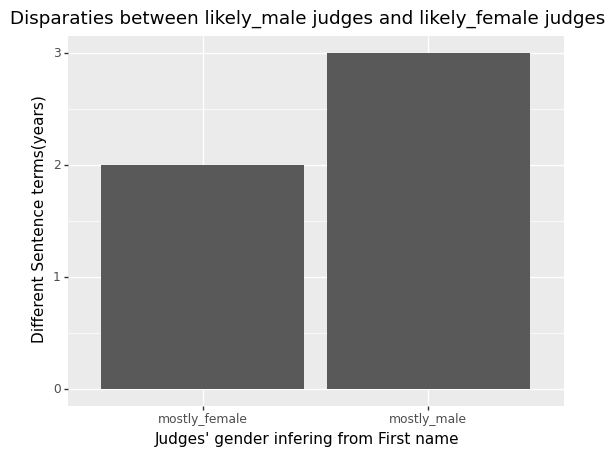

<ggplot: (8771959074395)>

In [87]:
# See the data
sentencing_cleaned.SENTENCE_JUDGE

# use a package from website
import gender_guesser.detector as gender

# Test the package
det=gender.Detector()
print(det.get_gender(u"Clayton"))

# Get every judge's first,middle and last name
name_df=sentencing_cleaned['SENTENCE_JUDGE'].str.split(" ",1,expand=True)
sentencing_cleaned['Firstname_judge']=name_df[0]
sentencing_cleaned['Othername_judge']=name_df[1]
sentencing_cleaned[['SENTENCE_JUDGE','Firstname_judge','Othername_judge']]

# infer the gender of each judge
sentence_judge_list=sentencing_cleaned.Firstname_judge.tolist()
sentencing_cleaned['Infer_judge_gender']=[det.get_gender(judge) for judge in sentence_judge_list]

pd.unique(sentencing_cleaned.Infer_judge_gender)
# filter data to 'likely female' and 'likely male'
sentencing_likely=sentencing_cleaned.loc[(sentencing_cleaned.Infer_judge_gender=='mostly_female')|(sentencing_cleaned.Infer_judge_gender=='mostly_male')]
sentence_likely_clean=sentencing_likely[['CASE_ID','CASE_PARTICIPANT_ID','SENTENCE_JUDGE','judgeid_derived','senlength_derived','Infer_judge_gender','Firstname_judge']]
sentence_likely_clean=sentence_likely_clean.groupby('Infer_judge_gender').agg({'senlength_derived': 'median'})
sentence_likely_clean

# change unit of senlength_derived from 'days' to 'years'
sentence_likely_clean['senlength_year']= sentence_likely_clean['senlength_derived']/ 365

sentence_likely_clean=sentence_likely_clean.reset_index(['Infer_judge_gender'])
# use ggplot to show the disparaties between likely_male and likely_female
(
    ggplot(sentence_likely_clean,aes(x="Infer_judge_gender",y="senlength_year"))
        +geom_bar(stat='identity',position = position_dodge())
        +labs(x="Judges' gender infering from First name",
              y="Different Sentence terms(years)",
             title="Disparaties between likely_male judges and likely_female judges")
)

# 3. Optional extra credit/challenge exercise (1 point): examine disparities across multiple judges

In problem 1.2, we focused on one judge: judge 21
    
For this extra credit exercise:
    
- Get judges with a sufficient sample size: filter to each judge with at least 20 Black and at least 20 white defendants
- Calculate the within-judge disparity and plot the (1) median sentence length for Black defendants and (2) median sentence length for white defendants (factor variable on x axis for each judge_id who qualifies; group by race)
- Write a 1-2 sentence interpretation - if we assume that cases/defendants are randomly assigned to sentencing judges, what might this suggest about the role of judicial discretion in these disparities?


,is_black_derived,is_white_derived,number_more_20
judgeid_derived,,,
judge_1,20,0,False
judge_10,64,9,False
judge_100,39,12,False
judge_105,38,3,False
judge_109,208,6,False
...,...,...,...
judge_89,28,8,False
judge_90,42,17,False
judge_92,7,3,False


array(['judge_334', 'judge_35', 'judge_20', 'judge_21', 'judge_36',
       'judge_133', 'judge_166', 'judge_279', 'judge_41', 'judge_177',
       'judge_320'], dtype=object)

,judgeid_derived,is_black_derived,is_white_derived,senlength_derived,senlength_year,Black_or_White
0,judge_133,False,True,365.0,1.000000,White
1,judge_133,True,False,488.0,1.336986,Balck
2,judge_166,False,True,365.0,1.000000,White
3,judge_166,True,False,365.0,1.000000,Balck
4,judge_177,False,True,365.0,1.000000,White
5,judge_177,True,False,730.0,2.000000,Balck
6,judge_20,False,True,365.0,1.000000,White
7,judge_20,True,False,730.0,2.000000,Balck
8,judge_21,False,True,730.0,2.000000,White
9,judge_21,True,False,1460.0,4.000000,Balck


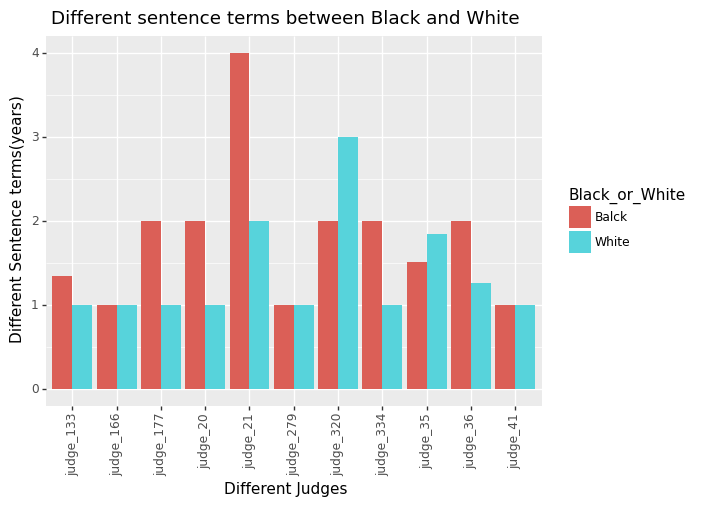

<ggplot: (8772056494077)>

In [88]:

# filter to only 'Narcotics'
sentencing_narc=sentencing_cleaned.loc[(sentencing_cleaned.simplified_offense_derived=='Narcotics')]

# groupby judge
sentencing_judgr=sentencing_narc.groupby('judgeid_derived').agg({'is_black_derived': 'sum',
                                               'is_white_derived':'sum'})

# filter to each judge with at least 20 Black and at least 20 white defendants
sentencing_judgr['number_more_20']=np.where((sentencing_judgr.is_black_derived>=20)&(sentencing_judgr.is_white_derived>=20),True,False)
sentencing_judgr
sentencing_narc_clean=sentencing_judgr.loc[sentencing_judgr.number_more_20==True]
sentencing_narc_clean_list=sentencing_narc_clean.index.tolist()

# Check the filter
sentencing_narc_plot=sentencing_narc.loc[sentencing_narc.judgeid_derived.isin(sentencing_narc_clean_list)==True]
pd.unique(sentencing_narc_plot['judgeid_derived'])

# Group by race for each judge
sentencing_narc_plot=sentencing_narc_plot.groupby(['judgeid_derived','is_black_derived','is_white_derived']).agg({'senlength_derived': 'median'})

# change unit of senlength_derived from 'days' to 'years'
sentencing_narc_plot['senlength_year']= sentencing_narc_plot['senlength_derived']/ 365
sentencing_narc_plot=sentencing_narc_plot.reset_index(['is_black_derived','is_white_derived','judgeid_derived'])

race_criteria=[sentencing_narc_plot.is_black_derived==True,
               sentencing_narc_plot.is_white_derived==True]
race_codeto=['Balck','White']
sentencing_narc_plot['Black_or_White']=np.select(race_criteria,race_codeto)
sentencing_narc_plot
# use ggplot to draw the graph
(
    ggplot(sentencing_narc_plot,aes(x="factor(judgeid_derived)",y="senlength_year",fill="Black_or_White"))
        +geom_bar(stat='identity',position = position_dodge())
        +labs(x="Different Judges",
              y="Different Sentence terms(years)",
             title="Different sentence terms between Black and White")+
    theme(axis_text_x=element_text(angle='90'))
)